In this tutorial, you will learn how to load a segment and visualize (if available), the ink labels that can be used to train an ink detection model.
### Getting Started:
First, we need to import the vesuvius package:

In [3]:
#!pip install vesuvius
#!vesuvius --accept_terms --yes;
import vesuvius
from vesuvius import Volume

Let us print the list of available segments for Scroll 1:

In [4]:
files = vesuvius.list_files()

In [5]:
for key, value in enumerate(files['1']['54']['7.91']['segments']): # the first entries are scroll_number, energy (keV), resolution (um)
    print(value)

20230503225234
20230504093154
20230504094316
20230504125349
20230504171956
20230504223647
20230504225948
20230504231922
20230505093556
20230505113642
20230505131816
20230505135219
20230505141722
20230505164332
20230505175240
20230506133355
20230507172452
20230507175928
20230508164013
20230508220213
20230509160956
20230509182749
20230510153006
20230510153843
20230510170242
20230511094040
20230511201612
20230511204029
20230511211540
20230511215040
20230511224701
20230512094635
20230512105719
20230512111225
20230512112647
20230512120728
20230512123446
20230512123540
20230512170431
20230513092954
20230513095916
20230513164153
20230514173038
20230514182829
20230515162442
20230516112444
20230516114341
20230516115453
20230517021606
20230517024455
20230517025833
20230517180019
20230517204451
20230517205601
20230518012543
20230518075340
20230518104908
20230518130337
20230518135715
20230518181521
20230518191548
20230518223227
20230519031042
20230519140147
20230519195952
20230519202000
2023051921

### Data download

We can work with segment `20230530212931`.

In [6]:
segment_id = 20230530212931
segment = Volume(segment_id)

As you have seen in the previous tutorial, the previous command only instantiate an object without downloading the data.
For a segment, the special method `segment.download_inklabels()` is automatically called and the ink labels, if available, are downloaded in the `self.inklabel` variable. If the ink labels are not available `segment.inklabel` will be an empty numpy array filled with 0s.

Let us visualize the layer that is supposed to be on the recto surface of the sheet of papyrus, which by convention is the number 32.

In [7]:
from matplotlib import pyplot as plt

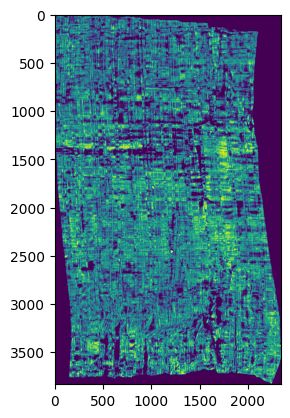

In [8]:
plt.imshow(segment[32])

This took a while! But caching is automatically activated in the `Volume` class, so the next iteration should take less time.

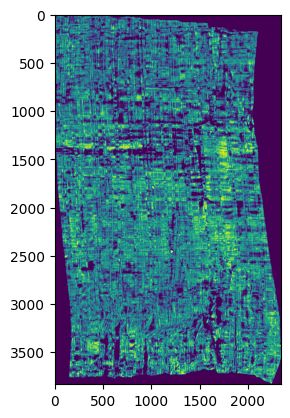

In [9]:
plt.imshow(segment[32])

We can visualize the ink labels for this segment:

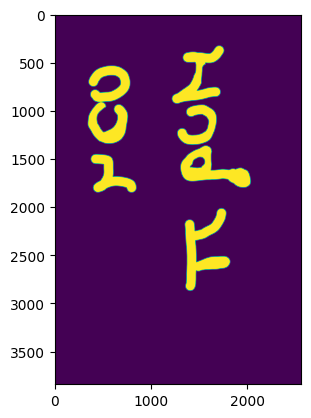

In [10]:
plt.imshow(segment.inklabel)

And the two overlayed:

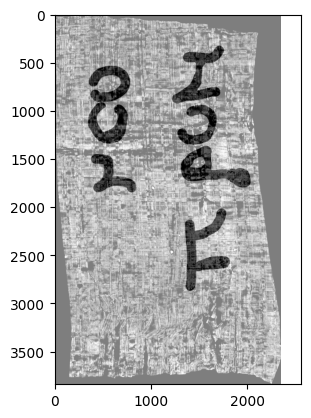

In [11]:
plt.imshow(segment[32], cmap='gray')
plt.imshow(segment.inklabel, cmap='binary', alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

## Ink Detection